In [1]:
import tensorflow as tf

In [2]:
g=tf.Graph()

In [3]:
with g.as_default():
    x=tf.placeholder(dtype=tf.float32,shape=(None),name='x')
    w=tf.Variable(2.0,name='weight')
    b=tf.Variable(0.7,name='bias')
    z=w*x + b
    init=tf.global_variables_initializer()

In [4]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    for t in [1.0,0.6,-1.8]:
        print('x=%4.1f-->z=%4.1f' %(t,sess.run(z,feed_dict={x:t})))

x= 1.0-->z= 2.7
x= 0.6-->z= 1.9
x=-1.8-->z=-2.9


In [5]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z,feed_dict={x:[1.,2.,3.]}))

[ 2.70000005  4.69999981  6.69999981]


In [6]:
#Working with array structure

In [7]:
import numpy as np

In [8]:
g=tf.Graph()
with g.as_default():
    x=tf.placeholder(dtype=tf.float32,shape=(None,2,3),name='input_x')
    x2=tf.reshape(x,shape=(-1,6),name='x2')
    xsum=tf.reduce_sum(x2,axis=0,name='col_sum')
    xmean=tf.reduce_mean(x2,axis=0,name='col_mean')

In [9]:
with tf.Session(graph=g) as sess:
    x_array=np.arange(18).reshape(3,2,3)
    print('input shape: ',x_array.shape)
    print('Reshaped :' ,sess.run(x2,feed_dict={x:x_array}))
    print('Column sum:\n' ,sess.run(xsum,feed_dict={x:x_array}))
    print('Column mean: \n',sess.run(xmean,feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped : [[  0.   1.   2.   3.   4.   5.]
 [  6.   7.   8.   9.  10.  11.]
 [ 12.  13.  14.  15.  16.  17.]]
Column sum:
 [ 18.  21.  24.  27.  30.  33.]
Column mean: 
 [  6.   7.   8.   9.  10.  11.]


In [10]:
#Developing a simple model with low level TesnorFlow API

In [11]:
X_train= np.arange(10).reshape((10,1))

In [12]:
y_train=np.array([1.0,1.3,3.1,
                  2.0,5.0,6.3,
                  6.6,7.4,8.0,
                  9.0])

In [13]:
class TFLinreg(object):
    def __init__(self,x_dim,learning_rate=0.01,random_seed=None):
        self.x_dim=x_dim
        self.learning_rate=learning_rate
        self.g=tf.Graph()
        
        with self.g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op=tf.global_variables_initializer()
    
    def build(self):
        self.X=tf.placeholder(dtype=tf.float32,shape=(None,self.x_dim),
                            name='x_input')
        self.y=tf.placeholder(dtype=tf.float32,shape=(None),name='y_input')
        print(self.X)
        print(self.y)
        w=tf.Variable(tf.zeros(shape=(1)),name='weight')
        b=tf.Variable(tf.zeros(shape=(1)),name='bias')
        print(w)
        print(b)
        self.z_net=tf.squeeze(w*self.X + b,name='z_net')
        print(self.z_net)
        square_errors=tf.square(self.y-self.z_net,name='sqr_errors')
        print(square_errors)
        self.mean_cost=tf.reduce_mean(square_errors,name='mean_cost')
        optimizer=tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        self.optimizer=optimizer.minimize(self.mean_cost)

In [14]:
lrmodel=TFLinreg(x_dim=X_train.shape[1],learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [15]:
def train_linreg(sess,model,X_train,y_train,num_epochs=10):
    sess.run(model.init_op)
    training_costs=[]
    for i in range(num_epochs):
        _,cost=sess.run([model.optimizer,model.mean_cost],feed_dict={model.X:X_train,model.y:y_train})

        training_costs.append(cost)
    return training_costs

In [16]:
sess=tf.Session(graph=lrmodel.g)
training_costs=train_linreg(sess,lrmodel,X_train,y_train)

In [17]:
import matplotlib.pyplot as plt

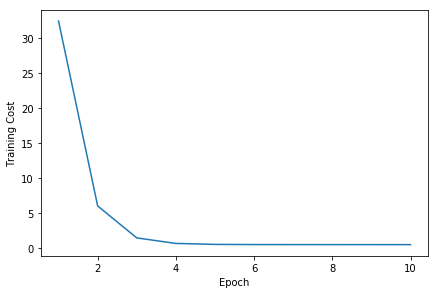

In [18]:
plt.plot(range(1,len(training_costs) +1),training_costs)
plt.tight_layout()
plt.xlabel("Epoch")
plt.ylabel('Training Cost')
plt.show()

In [19]:
def predict_linreg(sess,model,X_test):
    y_pred=sess.run(model.z_net,feed_dict={model.X:X_test})
    return y_pred

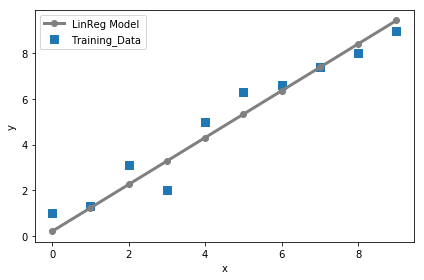

In [20]:
plt.scatter(X_train,y_train,marker='s',s=50,label='Training_Data')
plt.plot(range(X_train.shape[0]),predict_linreg(sess,lrmodel,X_train),
         color='gray',marker='o',markersize=6,linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
#Builiding multilayer neural networks using Tensorflow Layers API

In [22]:
#Laoding the data

In [24]:
import os
import struct
import numpy as np

In [49]:
def load_mnist(path,kind='train'):
    labels_path=os.path.join(path,'%s-labels.idx1-ubyte' %kind)
    image_path=os.path.join(path,'%s-images.idx3-ubyte' %kind)
    with open(labels_path,'rb') as lbpath:
        magic,n=struct.unpack('>II',lbpath.read(8))
        labels=np.fromfile(lbpath,dtype=np.uint8)
    with open(image_path, 'rb') as imgpath:
        magic,num,rows,cols=struct.unpack('>IIII',imgpath.read(16))
        
        images=np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels),784)
        images=((images/255.)-.5)*2
    return images,labels

In [50]:
X_train,y_train=load_mnist('C:\\Users\Satish\Desktop\Tensorflow-Bootcamp-master\Mynotes/MNIST_Data',kind='train')

In [51]:
X_test,y_test=load_mnist('C:\\Users\Satish\Desktop\Tensorflow-Bootcamp-master\Mynotes/MNIST_Data',kind='t10k')

In [52]:
mean_vals=np.mean(X_train,axis=0)

In [53]:
std_vals=np.std(X_train)

In [59]:
X_train_centered=(X_train-mean_vals)/std_vals

In [60]:
X_test_centered=(X_test-mean_vals)/std_vals

In [61]:
del X_train,X_test

In [62]:
print(X_train_centered.shape,y_train.shape)

(60000, 784) (60000,)


In [63]:
print(X_test_centered.shape,y_train.shape)

(10000, 784) (60000,)


In [64]:
n_features=X_train_centered.shape[1]

In [65]:
n_classes=10

In [66]:
random_seed=123

In [67]:
np.random.seed(random_seed)

In [68]:
g=tf.Graph()

In [72]:
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x=tf.placeholder(dtype=tf.float32,shape=(None,n_features),name='tf_x')
    tf_y=tf.placeholder(dtype=tf.int32,shape=None,name='tf_y')
    y_onehot=tf.one_hot(indices=tf_y,depth=n_classes)
    h1=tf.layers.dense(inputs=tf_x,units=50,activation=tf.tanh,name='layer1')
    h2=tf.layers.dense(inputs=h1,units=50,activation=tf.tanh,name='layer2')
    logits=tf.layers.dense(inputs=h2,units=10,activation=None,name='layer3')
    prediction={'classes': tf.argmax(logits,axis=1,name='predictied_classes'),
                'probabilities':tf.nn.softmax(logits,name='softmax_tensor')}

In [73]:
with g.as_default():
    cost=tf.losses.softmax_cross_entropy(onehot_labels=y_onehot,logits=logits)
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op=optimizer.minimize(loss=cost)
    init_op=tf.global_variables_initializer()

In [74]:
def create_batch_generator(X,y,batch_size=128,shuffle=False):
    X_copy=np.array(X)
    y_copy=np.array(y)
    
    if shuffle:
        data=np.column_stack((X_copy,y_copy))
        np.random.shuffle(data)
        X_copy=data[:,:-1]
        y_copy=data[:,-1].astype(int)
    for i in range(0,X.shape[0],batch_size):
        yield(X_copy[i:i+batch_size,:],y_copy[i:i+batch_size])

In [76]:
sess=tf.Session(graph=g)
sess.run(init_op)

for epoch in range(50):
    training_costs=[]
    batch_generator=create_batch_generator(X_train_centered,y_train,batch_size=64)
    
    for batch_X,batch_y in batch_generator:
        feed={tf_x:batch_X,tf_y:batch_y}
        _,batch_cost=sess.run([train_op,cost],feed_dict=feed)
        training_costs.append(batch_cost)
    print('--Epoch %2d '
          'Avg.Training Loass: %.4f' %(epoch+1 ,np.mean(training_costs)))

--Epoch  1 Avg.Training Loass: 1.5573
--Epoch  2 Avg.Training Loass: 0.9492
--Epoch  3 Avg.Training Loass: 0.7499
--Epoch  4 Avg.Training Loass: 0.6387
--Epoch  5 Avg.Training Loass: 0.5668
--Epoch  6 Avg.Training Loass: 0.5160
--Epoch  7 Avg.Training Loass: 0.4781
--Epoch  8 Avg.Training Loass: 0.4486
--Epoch  9 Avg.Training Loass: 0.4247
--Epoch 10 Avg.Training Loass: 0.4051
--Epoch 11 Avg.Training Loass: 0.3884
--Epoch 12 Avg.Training Loass: 0.3741
--Epoch 13 Avg.Training Loass: 0.3617
--Epoch 14 Avg.Training Loass: 0.3507
--Epoch 15 Avg.Training Loass: 0.3408
--Epoch 16 Avg.Training Loass: 0.3320
--Epoch 17 Avg.Training Loass: 0.3239
--Epoch 18 Avg.Training Loass: 0.3165
--Epoch 19 Avg.Training Loass: 0.3097
--Epoch 20 Avg.Training Loass: 0.3035
--Epoch 21 Avg.Training Loass: 0.2976
--Epoch 22 Avg.Training Loass: 0.2921
--Epoch 23 Avg.Training Loass: 0.2870
--Epoch 24 Avg.Training Loass: 0.2822
--Epoch 25 Avg.Training Loass: 0.2776
--Epoch 26 Avg.Training Loass: 0.2733
--Epoch 27 A

In [77]:
feed={tf_x:X_test_centered}

In [78]:
y_pred=sess.run(prediction['classes'],feed_dict=feed)

In [80]:
print('Test Accuracy %.2f' %(100*np.sum(y_pred==y_test)/y_test.shape[0]))

Test Accuracy 93.89
